# Phase transition in a hard-disk fluid

In [1]:
include("gnuplot.jl");

## The box

A box is created with random points. This points will become the centers of particles of a given radius. Notice that the distance from point to point (or center to center) restricts the possible radii that the particles can take without overlapping. To get any desired radius is just a matter of rescaling the system.

In [2]:
mutable struct Particle
    x::Float64
    y::Float64
    radius::Float64
end

mutable struct Box
    width::Float64
    height::Float64
    
    particles::Vector{Particle}
    
    grid::Matrix{Vector{Particle}}
    lx::Float64
    ly::Float64
    minCellWidth::Float64
    
    function Box(n::Int, radii::Vector{Float64})
        # Random particles inside a unit box.
        particles = [Particle(rand(),rand(),rand(radii)) for i in 1:n]
        
        # Get minimum separation distance between all
        # pairs of points.
        ii::Int = 1
        jj::Int = 1
        d2::Float64 = Inf
        for i in 1:n-1
            p::Particle = particles[i]
            for j in i+1:n
                q::Particle = particles[j]
                rx::Float64 = p.x - q.x
                ry::Float64 = p.y - q.y
                r2::Float64 = rx*rx + ry*ry
                if r2 < d2
                    ii = i
                    jj = j
                    d2 = r2
                end
            end
        end
        d::Float64 = sqrt(d2)/2.0 - 1e-10

        # Scale the system to get d to have two times
        # the size of the maximum possible radius.
        maxRadius = maximum(radii)
        particles[ii].radius = maxRadius
        particles[jj].radius = maxRadius
        f::Float64 = 2*maxRadius/d # scaling factor
        for p in particles
            p.x = f * p.x + maxRadius
            p.y = f * p.y + maxRadius
        end
        width = f + 2*maxRadius
        height = width    
        
        # Define space partitioning structure
        minCellWidth::Float64 = 3 * maxRadius
        nx::Int = floor(sqrt(n))
        lx::Float64 = width/nx
        if lx < minCellWidth
            nx = fld(width, minCellWidth)
            lx = width/nx
        end
        grid::Matrix{Vector{Particle}} = Matrix{Vector{Particle}}(undef, nx, nx)
        for col in 1:nx, row in 1:nx
            grid[row, col] = []
        end
        
        for p in particles
            col::Int = cld(p.x, lx)
            row::Int = cld(p.y, lx)
            push!(grid[row, col], p)
        end
        
        return new(width, height, particles, grid, lx, lx, minCellWidth)
    end
end

function getDensity(box::Box)
    area::Float64 = 0
    for p in box.particles
        r::Float64 = p.radius
        area += π*r*r
    end
    return area / (box.width * box.height)
end

getDensity (generic function with 1 method)

## Hard-disks collisions, a montecarlo process

Instead of physically colliding disks inside the box, we are simulating their dynamics with a montecarlo process:

- Randomly pick a disk inside the box and move it in a random direction with magnitude between 0 and 1. 
- If the particle overlaps with another one or if it leaves the box, then return particle to original position.

We can also reduce the volume of the box cuasi-statically to reach an optimal packing.

In [3]:
function montecarlo!(box::Box)
    # Random disk
    p::Particle = rand(box.particles)
    radius::Float64 = p.radius
    
    # Random movement of magnitude ∈ (0,radius).
    x::Float64 = -1 + 2*rand()
    y::Float64 = -1 + 2*rand()
    n::Float64 = sqrt(x*x + y*y) # Norm
    A::Float64 = rand() * radius # Random amplitude
    x = p.x + A*x/n
    y = p.y + A*y/n
    
    # Are there any overlaps inside the box?
    w::Float64 = box.width
    h::Float64 = box.height
    if (radius < x < w - radius) && (radius < y < h - radius)
        grid::Matrix{Vector{Particle}} = box.grid
        rows::Int = size(grid,1)
        cols::Int = size(grid,2)
        col::Int = cld(p.x, box.lx)
        row::Int = cld(p.y, box.ly)
        for c in col-1:col+1, r in row-1:row+1
            if 1 <= c <= cols && 1 <= r <= rows
                for q in grid[r, c]
                    if p === q; continue; end
                    d::Float64 = p.radius + q.radius
                    rx::Float64 = x - q.x
                    ry::Float64 = y - q.y
                    if rx*rx + ry*ry < d*d
                        return
                    end
                end
            end
        end
        # At this point we know for sure there are no overlaps.
        p.x = x
        p.y = y
        oldBucket = grid[row, col]
        col = cld(p.x, box.lx)
        row = cld(p.y, box.ly)
        newBucket = grid[row, col]
        k = findfirst(x -> x === p, oldBucket)
        deleteat!(oldBucket, k)
        push!(newBucket, p)
    end
end

function reduceVolume!(box::Box)
    w::Float64 = box.width
    h::Float64 = box.height
    dist2rightWall::Float64 = Inf
    dist2topWall::Float64 = Inf
    for p in box.particles
        dx::Float64 = w - p.radius - p.x
        dy::Float64 = h - p.radius - p.y
        if dx < dist2rightWall; dist2rightWall = dx; end
        if dy < dist2topWall; dist2topWall = dy; end
    end
    dist2wall::Float64 = min(dist2rightWall, dist2topWall)
    box.width = w - dist2wall/2.0
    box.height = h - dist2wall/2.0
    
    # Define space partitioning structure
    nx::Int = floor(sqrt(length(box.particles)))
    lx::Float64 = box.width/nx
    if lx < box.minCellWidth
        nx = fld(box.width, box.minCellWidth)
        lx = box.width/nx
    end
    grid::Matrix{Vector{Particle}} = Matrix{Vector{Particle}}(undef, nx, nx)
    for col in 1:nx, row in 1:nx
        grid[row, col] = []
    end

    for p in box.particles
        col::Int = cld(p.x, lx)
        row::Int = cld(p.y, lx)
        push!(grid[row, col], p)
    end
    box.grid = grid
    box.lx = lx
    box.ly = lx
end

function incrementVolume!(box::Box)
    box.width *= 1.001 # 0.1% increment
    updateGrid!(box)
end

incrementVolume! (generic function with 1 method)

### A fresh new box

Let's start a new box with $n$ disks of radius $r$ and measure its packing fraction $\phi$.

  0.000034 seconds (182 allocations: 11.781 KiB)


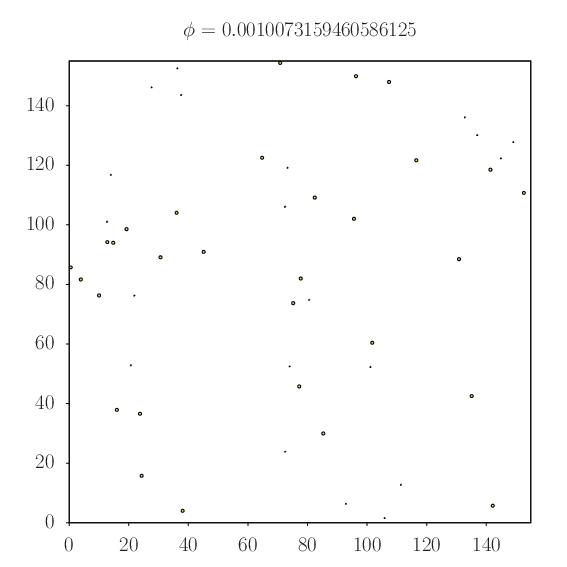

In [4]:
function test()
    n::Int = 50
    radii::Vector{Float64} = [0.5, 0.1]
    @time box::Box = Box(n,radii)
    w::Float64 = box.width
    h::Float64 = box.height
    phi::Float64 = getDensity(box)

    gp = gnuplot(20, 20)
    println(gp,
        "set size ratio -1;",
        "set tics out nomirror;",
        "set style fill solid 0.5 border 1;",
        "set xrange [0:$w];",
        "set yrange [0:$h];",
        "set title '\$\\phi = $phi\$';",
        "plot '-' with circles lc 2 notitle;")
    for p in box.particles
        println(gp, p.x, " ", p.y, " ", p.radius)
    end
    plot(gp)
    return box
end
box = test();

### An old box

Take the previous box and let the montecarlo process simulate its dynamics. After a given number of montecarlo steps try reducing the system's volume. This way, with each volume reducing step, the packing fraction will increase.

  2.876457 seconds (8.31 M allocations: 634.069 MiB, 2.77% gc time)


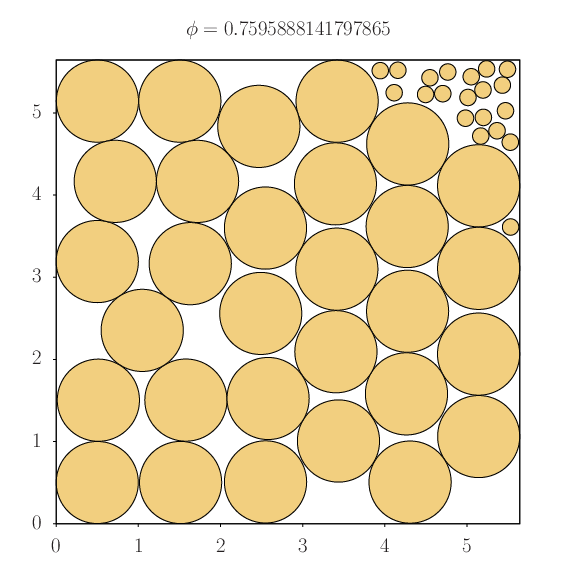

In [5]:
function simulation(box::Box, n::Int)
    steps::Int = length(box.particles)
    @time for i in 1:n
        for k in 1:steps; montecarlo!(box); end
        reduceVolume!(box)
    end

    w::Float64 = box.width
    h::Float64 = box.height
    phi::Float64 = getDensity(box)

    gp = gnuplot(20, 20)
    println(gp,
        "set size ratio -1;",
        "set tics out nomirror;",
        "set style fill solid 0.5 border 1;",
        "set xrange [0:$w];",
        "set yrange [0:$w];",
        "set title '\$\\phi = $phi\$';",
        "plot '-' with circles lc 2 notitle;")
    for p in box.particles
        println(gp, p.x, " ", p.y, " ", p.radius)
    end
    plot(gp)
end
simulation(box, 100000)

## Orientational order parameter

$$ \psi_6(R) = \frac{1}{N}\sum_{j=1}^N \bigg| \frac{1}{n} \sum_{k=1}^n \exp(i 6 \theta_{jk})\bigg| $$

where $R$ is a radius defining a circle concentric with particle $p_j$ and enclosing all particles $p_k$.

In [6]:
function psi6(pts::Vector{Vector{Float64}}, r::Float64)
    RePsi = 0
    ImPsi = 0
    psi6 = 0
    N = length(pts)
    for p in pts
        n = 0 # count p-neighbours
        for q in pts
            if p === q; continue; end
            rx = q[1] - p[1]
            ry = q[2] - p[2]
            d = rx*rx + ry*ry
            th = atan(ry,rx)
            if d < r
                RePsi += cos(6*th)
                ImPsi += sin(6*th)
                n += 1
            end
        end
        if n > 0
            psi6 += sqrt(RePsi*RePsi + ImPsi*ImPsi)/n
        end
    end
    return psi6/N
end

psi6 (generic function with 1 method)

### Plotting $\psi_6(R)$ for different densities $\phi$.

Plotted in units of the particles' diameter, $d$

In [ ]:
n = 100; r = 0.5
box = Box(n,r)

gp = gnuplot(32,14)
println(gp, "set cblabel '\$\\phi\$'; set palette negative;
    set format x '\$%1.0f d\$'; set ylabel '\$\\psi_6\$';
    set xrange [2*$r:128*$r];
    plot '-' w l lc palette notitle;")
for i in 1:4
    # Change box's density
    for j in 1:20000
        for k in 1:length(box.pts)
            montecarlo!(box)
        end
        reduceVolume!(box)
    end

    # Plot psi6(R) for fixed density
    phi = getDensity(box)
    for R in 2*r:1e-1:128*r
        p = psi6(box.pts, R)
        println(gp, "$R $p $phi")
    end
    println(gp)
end
plot(gp)

### Fixing $R$ and measuring $\psi_6^{(R)}(\phi)$

We observed in the previous result the values of $R$ that make the order parameter a measurable quantity. Taking one of this values we can then slowly change the box's density and measure $\psi_6$ to see where the phase transition takes place.

In [ ]:
n = 100; r = 0.5; R = 10*r;
box = Box(n,r)

gp = gnuplot(32,14)
println(gp, "set xlabel '\$\\phi\$'; set ylabel '\$\\psi_6^{(R)}\$';
    plot '-' w l notitle;")
for i = 1:1000
    phi = getDensity(box)
    psi = psi6(box.pts, R)
    println(gp, "$phi $psi")
    for j in 1:100
        for k in 1:length(box.pts)*2
            montecarlo!(box)
        end
        reduceVolume!(box)
    end
end
plot(gp)

[10] Repite el ejercicio 9, esta vez comenzando con un sistema muy denso y ordenado para después bajar la densidad. 

[11] Prueba diferentes velocidades con las que incrementes o disminuyas la densidad cerca del punto crítico. 